In [68]:
import psycopg2
import pandas as pd
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords
import string
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from src import galgraphs
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def retrieve_reviews(product):
    conn = psycopg2.connect(dbname='product_reviews', user='postgres', password='', host='localhost')
    cursor = conn.cursor()
    p_no = 0
    r_no = 0
    cursor.execute("select * from reviews where product_name = '{}'".format(product))
    rows = cursor.fetchall()
    df = pd.DataFrame(rows)
    cursor.close()
    conn.close()
    return df

def retrieve_all_reviews():
    conn = psycopg2.connect(dbname='product_reviews', user='postgres', password='', host='localhost')
    cursor = conn.cursor()
    p_no = 0
    r_no = 0
    cursor.execute("select * from reviews")
    rows = cursor.fetchall()
    df = pd.DataFrame(rows)
    cursor.close()
    conn.close()
    return df


In [9]:
df = retrieve_all_reviews()
columns = ['id','p_name','url','p_no','r_no','r_stars','r_date','r_name','r_title','r_text','r_comments']
df.columns = columns
df.head(2)

,id,p_name,url,p_no,r_no,r_stars,r_date,r_name,r_title,r_text,r_comments
0,1,LG Electronics 65UJ6300 65-Inch 4K Ultra HD Sm...,https://www.amazon.com/LG-Electronics-65UJ6300...,1,1,5.0 out of 5 stars,"September 22, 2017",Prime Customer,"TV Great, TruMotion Bad!",Now that I found the TruMotion setting so that...,Verified Purchase Helpful No...
1,2,LG Electronics 65UJ6300 65-Inch 4K Ultra HD Sm...,https://www.amazon.com/LG-Electronics-65UJ6300...,1,2,5.0 out of 5 stars,"December 30, 2017",GMC,Hint: Turn OFF Smart Picture Mode,Hint: Turn off Smart Picture Mode and then tur...,Verified Purchase Helpful No...


In [11]:
df_new = df.copy()
df_new = df_new[df_new['r_stars'].apply(lambda x: x in ['5.0 out of 5 stars','1.0 out of 5 stars'])]
df_new['rating'] = df_new['r_stars'].apply(lambda x: 1 if x == '5.0 out of 5 stars' else 0)
df_new = df_new[['rating','p_name','r_name','r_title','r_text']]
df_new.head(3)

,rating,p_name,r_name,r_title,r_text
0,1,LG Electronics 65UJ6300 65-Inch 4K Ultra HD Sm...,Prime Customer,"TV Great, TruMotion Bad!",Now that I found the TruMotion setting so that...
1,1,LG Electronics 65UJ6300 65-Inch 4K Ultra HD Sm...,GMC,Hint: Turn OFF Smart Picture Mode,Hint: Turn off Smart Picture Mode and then tur...
2,1,LG Electronics 65UJ6300 65-Inch 4K Ultra HD Sm...,AncientGhost,43UJ6300,Needed an upgrade for my 7yr old HDTV and deci...


In [12]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bhaskarballapragada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
# import string
# stopwords = set(stopwords.words('english'))
# punctuation = set(string.punctuation)
# lemmatize = WordNetLemmatizer()

# def cleaning(article):
#     one = " ".join([i for i in article.lower().split() if i not in stopwords])
#     two = "".join(i for i in one if i not in punctuation)
#     three = " ".join(lemmatize.lemmatize(i) for i in two.split())
#     return three

# df_text = df_new[['r_text']]
# df_text.info()

# data = df_text.applymap(cleaning)['r_text']
# text = data
# text_list = [i.split() for i in text]
# len(text_list)

In [172]:
from sklearn.model_selection import train_test_split
df_new['des'] = df_new['r_title'] + " " + df_new['r_text']
df_new.head(2)
X_train, X_test, y_train, y_test = train_test_split(df_new['des'], df_new['rating'], train_size=0.8)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [173]:
def pos_neg_sentiments(df_product):
    #positive sentiments
    g = df_product.groupby('p_name')
    for name, group in g:
        tfidf = TfidfVectorizer(stop_words='english',max_features=10000)
        X_descr_vectors = tfidf.fit_transform(group['des'])
        nb = MultinomialNB()
        nb.fit(X_descr_vectors, group['rating'].transpose()) 
        y_hat = nb.predict_proba(X_descr_vectors)
        arr = np.argsort(nb.feature_log_prob_[0])[-30:-1]
        print (name)
        list_of_words = []
        for i in arr:
            list_of_words.append(tfidf.get_feature_names()[i])
        print ("\t",list_of_words)
        print ("______________________________________________________________________________")

In [174]:
print (pos_neg_sentiments(df_new[df_new['rating'] == 0]))

/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


LG 60SJ8000 60-Inch 4K TV - Smart - HDR - LED - SJ8000
	 ['sony', 'giving', 'buying', 'buy', 'trouble', 'bought', 'changed', 'came', 'samsung', 'auto', 'days', 'dim', 'products', 'lg', 'power', 'performed', 'worst', 'dimmest', 'currently', 'section', 'listed', 'box', 'customer', 'open', 'damage', 'service', 'cracks', 'picture', 'oled']
______________________________________________________________________________
LG 65SJ8000 65 WebOS 3.5 Smart UHD 4K HDR LED HDTV
	 ['models', 'logo', 'like', 'helmets', 'lower', 'clear', 'better', 'blurry', 'close', 'hd', 'awful', 'tvs', 'bad', 'banding', 'problem', 'buy', 'hockey', 'number', 'defective', 'motion', 'distracting', 'vertical', 'especially', 'issue', 'panning', 'tv', 'extremely', 'picture', 'watching']
______________________________________________________________________________
LG Electronics 65UJ6300 65-Inch 4K Ultra HD Smart LED TV (2017 Model)
	 ['bought', 'just', 'went', 'working', 'white', 'disappointed', 'arrival', 'defective', 'ba

In [175]:
print (pos_neg_sentiments(df_new[df_new['rating'] == 1]))

/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


LG 60SJ8000 60-Inch 4K TV - Smart - HDR - LED - SJ8000
	 ['blow', 'going', 'omg', 'looks', 'samsung', 'product', 'cool', 'outstanding', 'uhd', 'good', 'crystal', 'clear', 'new', 'love', 'tvs', 'oled', '120', 'really', 'picked', 'better', 'happy', 'lg', '60', 'seller', 'exellent', 'stars', 'picture', 'great', 'best']
______________________________________________________________________________
LG 65 Class 4K UHD HDR Smart LED TV - 65UJ6540
	 ['easy', 'excellent', 'inch', 'replacing', 'saving', 'just', '4k', 'club', 'power', 'connection', 'luxury', 'response', 'fast', 'seller', 'resolution', 'ship', 'skin', 'deal', 'purchased', '65', 'box', 'price', 'local', 'uhd', 'wonderful', 'love', 'stars', 'picture', 'great']
______________________________________________________________________________
LG 65SJ8000 65 WebOS 3.5 Smart UHD 4K HDR LED HDTV
	 ['im', 'wall', 'hot', 'sound', 'just', 'real', 'ive', 'brilliant', 'interface', 'price', '4k', 'clear', 'remote', 'love', 'lg', 'set', 'great', '

In [73]:
# create tfidf for all postivie and negative ratings
tfidf = TfidfVectorizer(stop_words='english',max_features=10000)
X_train_descr_vectors = tfidf.fit_transform(X_train)
X_test_descr_vectors = tfidf.transform(X_test)

# create tfidf for all products within positive ratings
X_pos = df_new[df_new['rating'] == 1]['des']
y_pos = df_new[df_new['rating'] == 1]['p_name']
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos, y_pos, train_size=0.8)

tfidf_pos = TfidfVectorizer(stop_words='english',max_features=10000)
X_pos_train_descr_vectors = tfidf_pos.fit_transform(X_pos_train)
X_pos_test_descr_vectors = tfidf_pos.transform(X_pos_test)

# create tfidf for all products within negative ratings
X_neg = df_new[df_new['rating'] == 0]['des']
y_neg = df_new[df_new['rating'] == 0]['p_name']
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg, y_neg, train_size=0.8)

tfidf_neg = TfidfVectorizer(stop_words='english',max_features=10000)
X_neg_train_descr_vectors = tfidf_neg.fit_transform(X_neg_train)
X_neg_test_descr_vectors = tfidf_neg.transform(X_neg_test)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [74]:
X_train_descr_vectors.todense().shape, X_pos_descr_vectors.todense().shape, X_neg_descr_vectors.todense().shape

((2813, 8900), (2867, 8085), (650, 4784))

In [75]:
y_train.shape, y_test.shape

((2813,), (704,))

0.8752221827230715


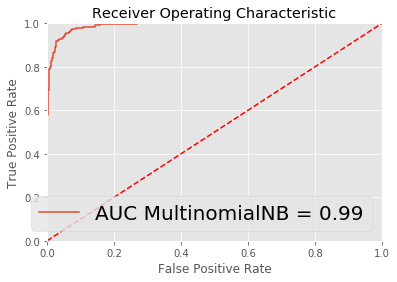

0.859375


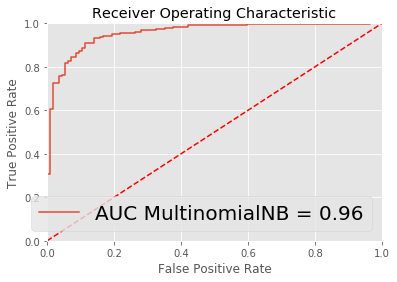

In [80]:
nb = MultinomialNB()
nb.fit(X_train_descr_vectors, y_train.transpose())
y_hat_train = nb.predict_proba(X_train_descr_vectors)
y_hat = nb.predict_proba(X_test_descr_vectors)

log_loss(y_train, y_hat_train)
print(nb.score(X_train_descr_vectors, y_train))

fig, ax = plt.subplots(1,1)
galgraphs.plot_roc(ax, nb, X_train_descr_vectors.todense(), y_train)
plt.show()

log_loss(y_test, y_hat)
print(nb.score(X_test_descr_vectors, y_test))
# np.argmax(y_hat, axis=1)
# y_test
# X_test_descr_vectors.shape[0]
# X_test_descr_vectors.shape
# nb.decision


# galgraphs.roc_curve(y_test_one_hot, y_hat[:,0])
fig, ax = plt.subplots(1,1)
galgraphs.plot_roc(ax, nb, X_test_descr_vectors.todense(), y_test)
plt.show()

In [151]:
arr_0 = np.argsort(nb.feature_log_prob_[0])[-30:-1]
for i in arr_0:
    print (tfidf.get_feature_names()[i])

cracked
lg
like
picture
smart
bought
days
turn
dont
remote
time
tvs
new
amazon
problem
working
support
warranty
work
just
months
box
customer
broken
return
service
buy
screen
samsung


In [152]:
arr_1 = np.argsort(nb.feature_log_prob_[1])[-30:-1]
for i in arr_1:
    print (tfidf.get_feature_names()[i])

just
excellent
clear
really
beautiful
product
nice
use
starsexcellent
happy
awesome
best
smart
like
starslove
remote
amazing
4k
set
samsung
sound
easy
price
quality
good
love
starsgreat
picture
great


In [79]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_pos_train)
y_pos_train_one_hot = lb.transform(y_pos_train)
y_pos_test_one_hot = lb.transform(y_pos_test)

nb = MultinomialNB()
nb.fit(X_pos_train_descr_vectors, y_pos_train.transpose())
y_pos_hat_train = nb.predict_proba(X_pos_train_descr_vectors)
y_pos_hat = nb.predict_proba(X_pos_test_descr_vectors)

log_loss(y_pos_train_one_hot, y_pos_hat_train)
train_score = nb.score(X_pos_train_descr_vectors, y_pos_train)

# fig, ax = plt.subplots(1,1)
# galgraphs.plot_roc(ax, nb, X_pos_train_descr_vectors.todense(), y_pos_train)
# plt.show()

log_loss(y_pos_test_one_hot, y_pos_hat)
test_score = nb.score(X_pos_test_descr_vectors, y_pos_test)
# np.argmax(y_hat, axis=1)
# y_test
# X_test_descr_vectors.shape[0]
# X_test_descr_vectors.shape
# nb.decision

y_pos_test_one_hot
# galgraphs.roc_curve(y_test_one_hot, y_hat[:,0])
# fig, ax = plt.subplots(1,1)
# galgraphs.plot_roc(ax, nb, X_pos_test_descr_vectors.todense(), y_pos_test)
# plt.show()
train_score, test_score

(0.36197121674662014, 0.36585365853658536)